In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

In [86]:
LATENT_DIM = 1024
IMAGE_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Dodajemy augmentację
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Dodajemy augmentację
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [88]:
train_dataset = ImageFolder(root=Path('./afhq/train'), transform=transform)
val_dataset = ImageFolder(root=Path('./afhq/val'), transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [89]:

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Używamy pre-trained ResNet50 jako enkodera
        resnet = models.resnet50(pretrained=True)
        # Pobieramy wszystkie warstwy do ostatniego bloku konwolucyjnego (pomijamy avgpool i fc)
        self.encoder_cnn = nn.Sequential(*list(resnet.children())[:-2])
        # Dla wejścia o rozmiarze 128x128, wyjście z encoder_cnn to tensor o wymiarach (batch, 2048, 4, 4)
        # Mapujemy 2048 kanałów do 1024, aby zachować spójność z dalszą częścią architektury
        self.encoder_mapping = nn.Conv2d(2048, 1024, kernel_size=1)
        
        # Opcjonalnie: zamrożenie wag pretrenowanego enkodera, jeśli chcemy wykorzystać wyłącznie wyuczone cechy
        # for param in self.encoder_cnn.parameters():
        #     param.requires_grad = False
            
        # for param in resnet.layer4.parameters():
        #     param.requires_grad = True
            
        # for param in resnet.layer3.parameters():
        #     param.requires_grad = True
            
        # for param in resnet.layer2.parameters():
        #     param.requires_grad = True
            
        
        self.fc_mu = nn.Linear(1024 * 2 * 2, LATENT_DIM)
        self.fc_var = nn.Linear(1024 * 2 * 2, LATENT_DIM)

        self.decoder_input = nn.Linear(LATENT_DIM, 1024 * 2 * 2)
        
        # Dekoder – architektura pozostaje bez zmian
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 1024, 3, stride=1, padding=1),  # 2x2 -> 2x2
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def encode(self, x):
        x = self.encoder_cnn(x)           # Wyjście: (batch, 2048, 4, 4)
        x = self.encoder_mapping(x)         # Po mapowaniu: (batch, 1024, 4, 4)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 1024, 2, 2)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [90]:
# model = VAE().to(DEVICE)
# model.load_state_dict(torch.load('vae_best.pth', map_location=DEVICE))
# model.eval()

In [91]:
model = VAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Dodajemy regularyzację
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [92]:
def loss_function(recon_x, x, mu, log_var, kld_weight=0.0025):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    L1 = F.l1_loss(recon_x, x, reduction='sum')
    reconstruction_loss = MSE + 0.5 * L1
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kld_weight * KLD

In [93]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 5 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item() / len(data):.4f}')
    
    avg_loss = train_loss / len(train_dataloader.dataset)
    print(f'Epoch: {epoch}, Average Loss: {avg_loss:.4f}')
    scheduler.step(avg_loss)
    
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'fully_unlocked_vae_epoch_{epoch}.pth')
    
    return avg_loss

In [94]:
def visualize_results(epoch, n_samples=10):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(train_dataloader))
        data = data[:n_samples].to(DEVICE)
        recon, _, _ = model(data)
        z = torch.randn(n_samples, LATENT_DIM).to(DEVICE)
        generated = model.decode(z)
        
        plt.figure(figsize=(15, 5))
        for i in range(n_samples):
            plt.subplot(3, n_samples, i + 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            plt.axis('off')
        for i in range(n_samples):
            plt.subplot(3, n_samples, i + 1 + n_samples)
            plt.imshow(recon[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            plt.axis('off')
        for i in range(n_samples):
            plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
            plt.imshow(generated[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            plt.axis('off')
            
        plt.tight_layout()
        plt.savefig(f'fully_unlocked_results_epoch_{epoch}.png')
        plt.close()


In [95]:
best_loss = float('inf')
for epoch in range(1, EPOCHS + 1):
    loss = train(epoch)
    visualize_results(epoch)
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'vae_best.pth')

Epoch: 1, Batch: 0, Loss: 7350.8823
Epoch: 1, Batch: 5, Loss: 6783.3369
Epoch: 1, Batch: 10, Loss: 5748.4380
Epoch: 1, Batch: 15, Loss: 5193.0972
Epoch: 1, Batch: 20, Loss: 5731.3774
Epoch: 1, Batch: 25, Loss: 5717.3979
Epoch: 1, Batch: 30, Loss: 4967.3433
Epoch: 1, Batch: 35, Loss: 4908.5923
Epoch: 1, Batch: 40, Loss: 4779.0127
Epoch: 1, Batch: 45, Loss: 5123.7871
Epoch: 1, Batch: 50, Loss: 5162.9355
Epoch: 1, Batch: 55, Loss: 5256.4106
Epoch: 1, Batch: 60, Loss: 5187.9351
Epoch: 1, Batch: 65, Loss: 5102.2354
Epoch: 1, Batch: 70, Loss: 5740.1255
Epoch: 1, Batch: 75, Loss: 5341.0527
Epoch: 1, Batch: 80, Loss: 5220.7969
Epoch: 1, Batch: 85, Loss: 4732.1748
Epoch: 1, Batch: 90, Loss: 4569.6162
Epoch: 1, Batch: 95, Loss: 4885.5317
Epoch: 1, Batch: 100, Loss: 4659.0811
Epoch: 1, Batch: 105, Loss: 4978.4624
Epoch: 1, Batch: 110, Loss: 4877.3887
Epoch: 1, Batch: 115, Loss: 4568.4536
Epoch: 1, Batch: 120, Loss: 5124.6724
Epoch: 1, Batch: 125, Loss: 5058.9292
Epoch: 1, Batch: 130, Loss: 4910.2

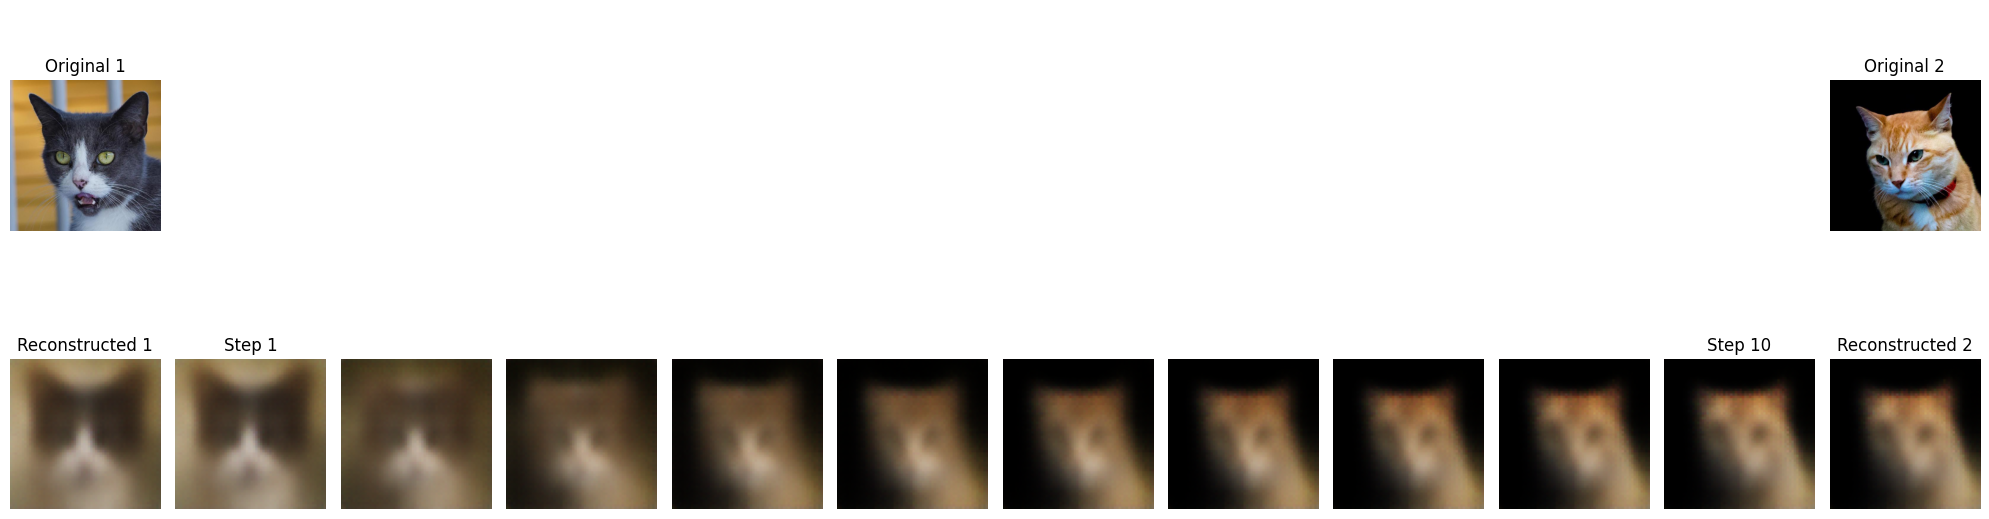

In [96]:
def interpolate_images_advanced(model, image1_path, image2_path, steps=10, method='spherical'):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    img1 = Image.open(image1_path).convert('RGB')
    img2 = Image.open(image2_path).convert('RGB')

    img1_tensor = transform(img1).unsqueeze(0).to(DEVICE)
    img2_tensor = transform(img2).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        mu1, _ = model.encode(img1_tensor)
        mu2, _ = model.encode(img2_tensor)

        def linear_interpolation(v1, v2, alpha):
            return v1 * (1 - alpha) + v2 * alpha

        def spherical_interpolation(v1, v2, alpha):
            v1_norm = F.normalize(v1, dim=1)
            v2_norm = F.normalize(v2, dim=1)

            dot = (v1_norm * v2_norm).sum(1, keepdim=True).clamp(-1.0, 1.0)
            omega = torch.acos(dot)
            sin_omega = torch.sin(omega)

            if torch.any(sin_omega == 0):
                return linear_interpolation(v1, v2, alpha)

            term1 = torch.sin((1.0 - alpha) * omega) / sin_omega
            term2 = torch.sin(alpha * omega) / sin_omega
            return term1 * v1 + term2 * v2

        interpolation_func = spherical_interpolation if method == 'spherical' else linear_interpolation

        vectors = []
        for alpha_val in np.linspace(0, 1, steps):
            alpha_tensor = torch.tensor([[alpha_val]], dtype=mu1.dtype, device=DEVICE)
            interpolated = interpolation_func(mu1, mu2, alpha_tensor)
            vectors.append(interpolated)

        fig, axes = plt.subplots(2, steps + 2, figsize=(20, 6))

        recon1, _, _ = model(img1_tensor)
        recon2, _, _ = model(img2_tensor)

        axes[0, 0].imshow(img1)
        axes[0, 0].axis('off')
        axes[0, 0].set_title('Original 1')

        recon_img1 = recon1[0].cpu().permute(1, 2, 0) * 0.5 + 0.5
        axes[1, 0].imshow(recon_img1.clamp(0, 1))
        axes[1, 0].axis('off')
        axes[1, 0].set_title('Reconstructed 1')

        for i, vec in enumerate(vectors):
            decoded = model.decode(vec.to(DEVICE))
            img = decoded[0].cpu().permute(1, 2, 0) * 0.5 + 0.5
            axes[0, i + 1].axis('off')
            axes[1, i + 1].imshow(img.clamp(0, 1))
            axes[1, i + 1].axis('off')
            if i == 0 or i == steps - 1:
                axes[1, i + 1].set_title(f'Step {i + 1}')

        axes[0, -1].imshow(img2)
        axes[0, -1].axis('off')
        axes[0, -1].set_title('Original 2')

        recon_img2 = recon2[0].cpu().permute(1, 2, 0) * 0.5 + 0.5
        axes[1, -1].imshow(recon_img2.clamp(0, 1))
        axes[1, -1].axis('off')
        axes[1, -1].set_title('Reconstructed 2')

        plt.tight_layout()
        plt.savefig(f'interpolation_{method}.png')
        plt.show()


# Przykład użycia funkcji interpolacji:
interpolate_images_advanced(model, 'afhq/train/cat/flickr_cat_000003.jpg', 'afhq/train/cat/pixabay_cat_004569.jpg', 
                            steps=10, method='spherical')